In [1]:
import struct
from PIL import Image
import numpy as np

def read_record_ETL8G(f):
    s = f.read(8199)
    r = struct.unpack('>2H8sI4B4H2B30x8128s11x', s)
    iF = Image.frombytes('F', (128, 127), r[14], 'bit', 4)
    iL = iF.convert('L')
    return r + (iL,)

def read_kanji():
    kanji = np.zeros([883, 160, 127, 128], dtype=np.uint8)
    for i in range(1, 33):
        filename = 'D:/ETL8G/ETL8G_{:02d}'.format(i)
        with open(filename, 'rb') as f:
            for dataset in range(5):
                char = 0
                for j in range(956):
                    r = read_record_ETL8G(f)
                    if not (b'.HIRA' in r[2] or b'.WO.' in r[2]): 
                        kanji[char, (i - 1) * 5 + dataset] = np.array(r[-1])
                        char += 1
    np.savez_compressed("kanji.npz", kanji)

read_kanji()

KeyboardInterrupt: 

In [2]:
import skimage.transform as tr
import numpy as np
from sklearn.model_selection import train_test_split

kanji = 879
rows = 64
cols = 64

kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)
#code use for less kanji in set
#train_images_numbers = np.arange(600)
#train_images_rest = np.array([614,687,695,741,754,797,872,875,880])


#train_images_numbers = np.concatenate((train_images_numbers, train_images_rest))

#train_images_before = np.zeros([(len(train_images_numbers)-4) * 160, rows, cols], dtype=np.float32)


#train_labels_numbers = [26,64,158,209,321,328,331,394,480,610,683,750,793,876]
#h = 0
#for i in range(len(train_images_numbers)):
#	if( train_images_numbers[i] == 88 or train_images_numbers[i]  == 219 or train_images_numbers[i]  == 349 or train_images_numbers[i]  == 457 ): 
#		h +=1
#		continue
#	else :
#		for j in range(160):
#			train_images_before[(i-h)*160+j] = tr.resize(kan[(train_images_numbers[i])*160+j],(rows,cols))
#
#train_labels_numbers = np.arange(len(train_images_numbers)-4)

train_images_before = np.zeros([(kanji) * 160, rows, cols], dtype=np.float32)
h = 0
for i in range(kanji+4):
	if( i == 88 or i  == 219 or i  == 349 or i  == 457 ): 
		h +=1
		continue
	else :
		for j in range(160):
			train_images_before[(i-h)*160+j] = tr.resize(kan[i*160+j],(rows,cols))

train_labels = np.arange(kanji)			
train_labels = np.repeat(train_labels, 160)

train_images, test_images, train_labels, test_labels = train_test_split(train_images_before, train_labels, test_size=0.2)

np.savez_compressed("kanji_train_images.npz", train_images)
np.savez_compressed("kanji_train_labels.npz", train_labels)
np.savez_compressed("kanji_test_images.npz", test_images)
np.savez_compressed("kanji_test_labels.npz", test_labels)





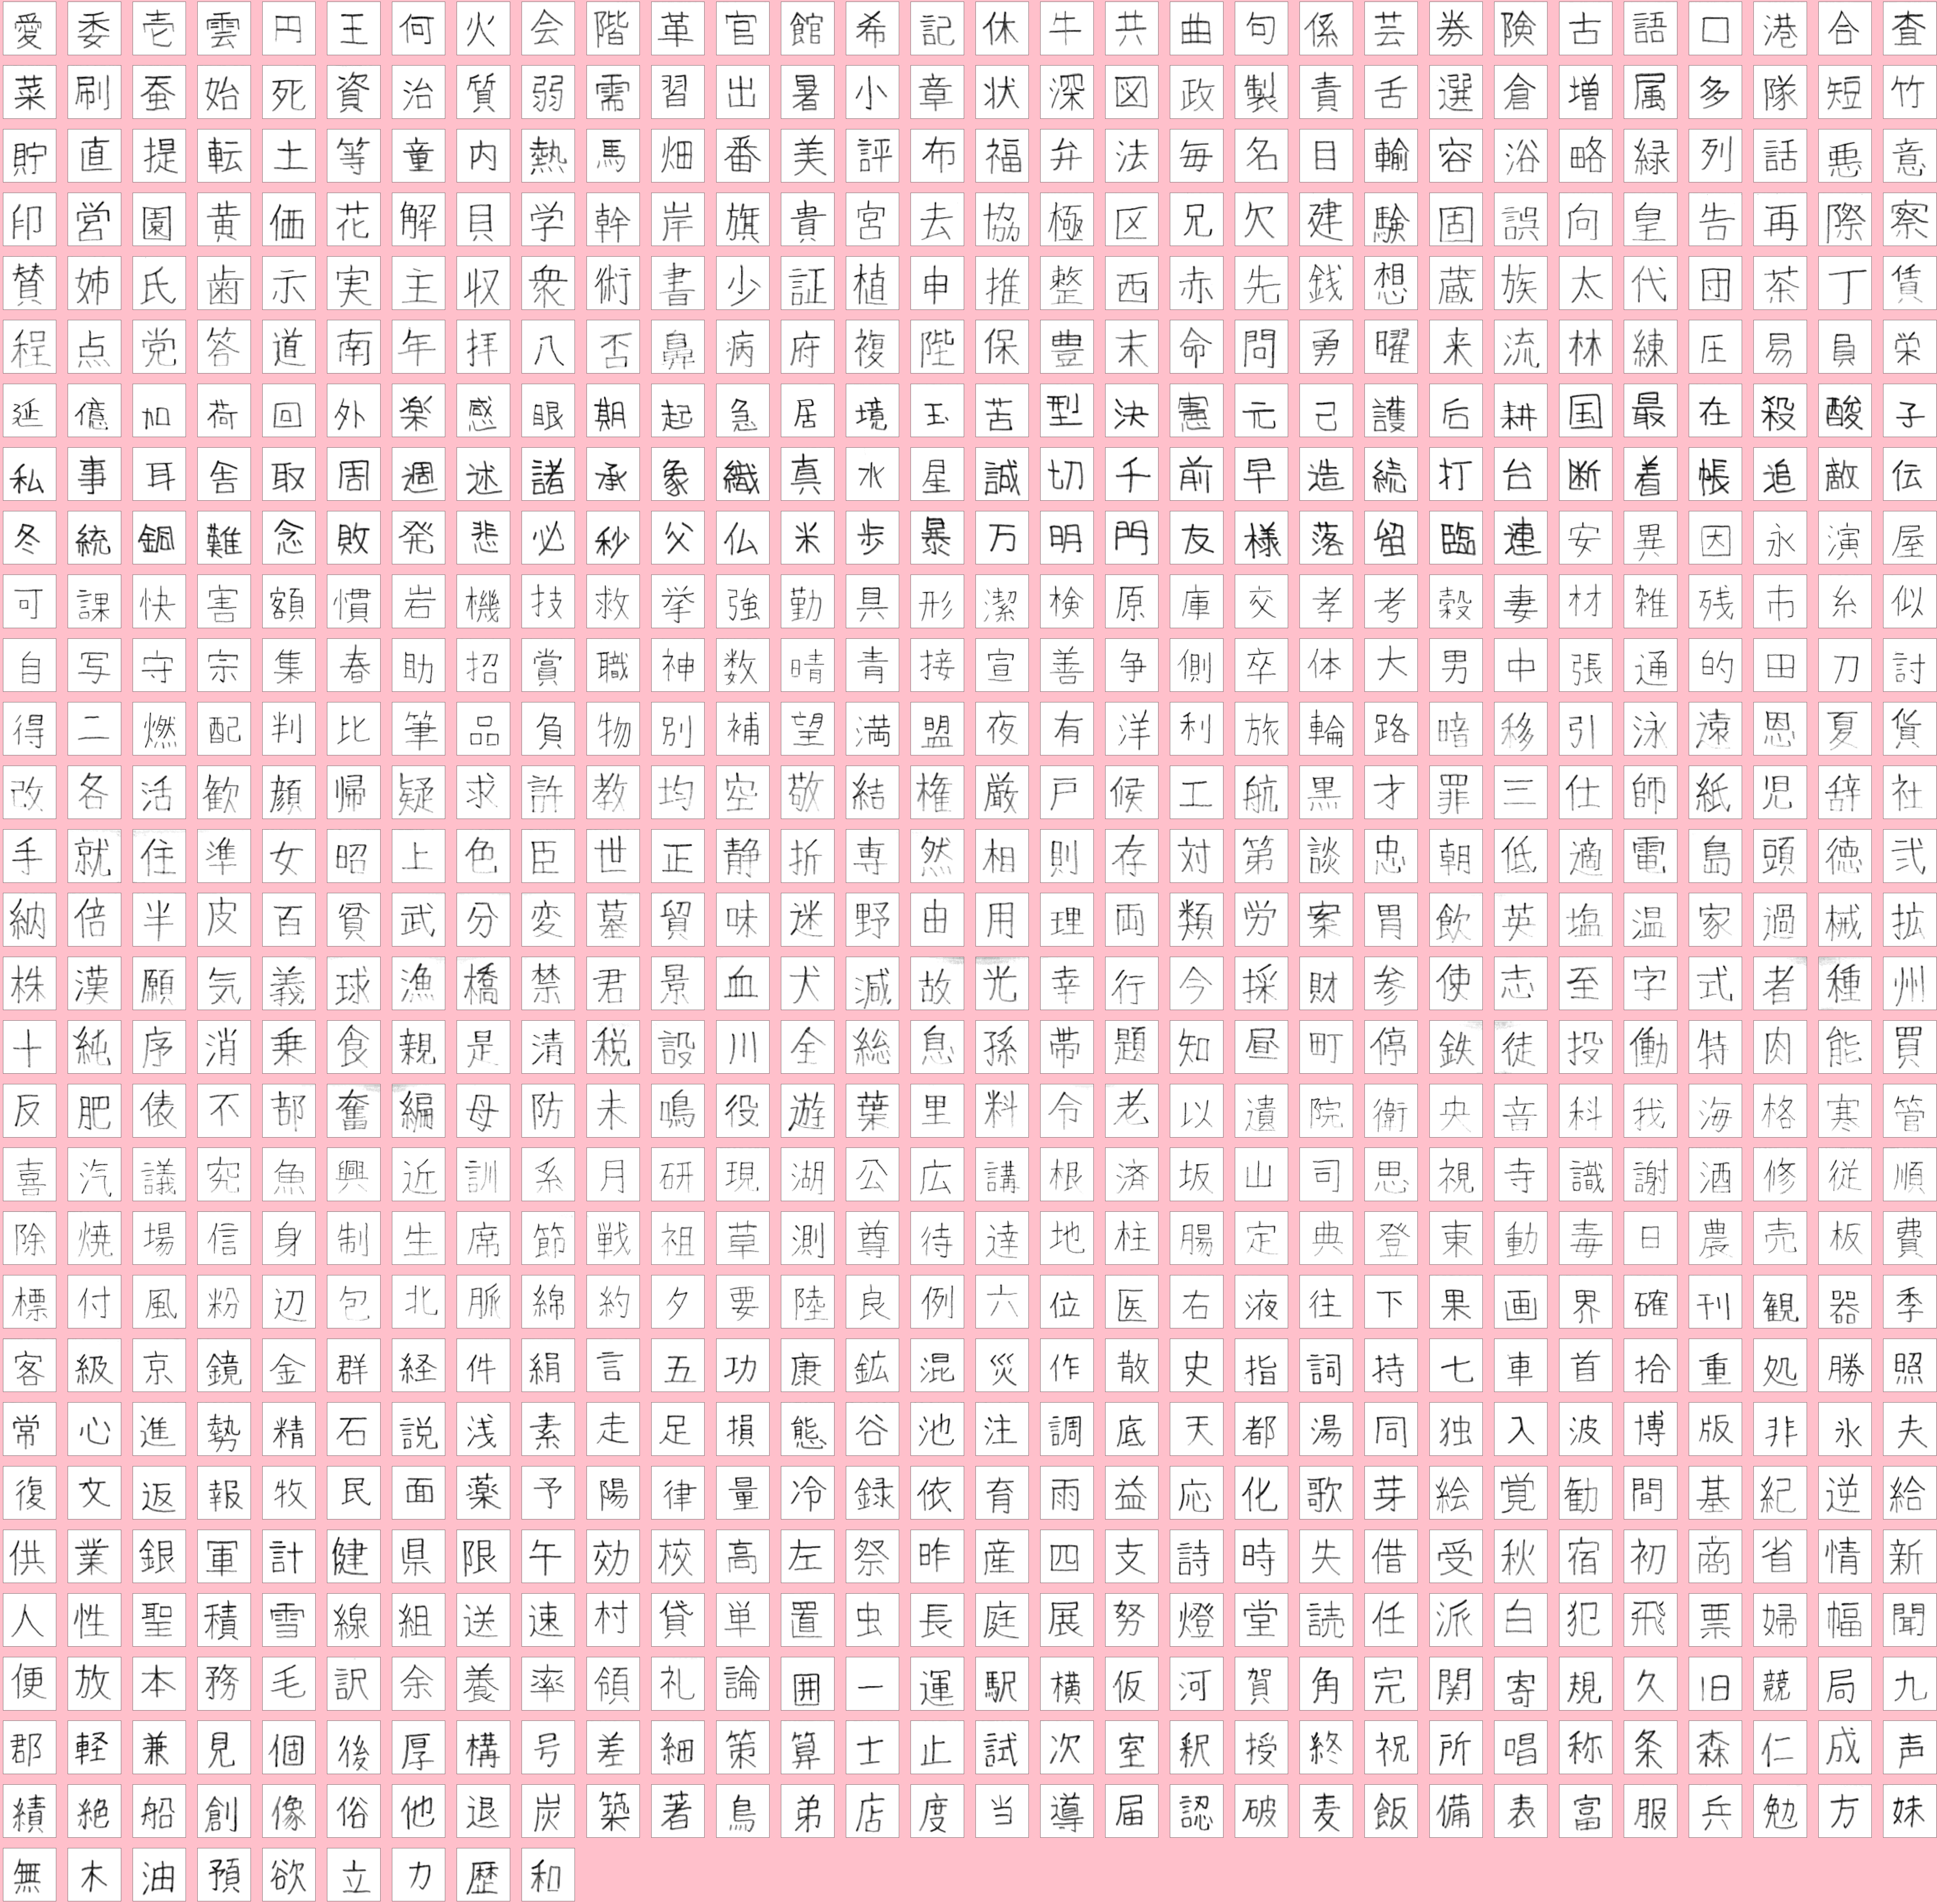

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(127,128)).patch.set_facecolor('pink')
for i in range(kanji):
    plt.subplot(30,30,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_before[i*160], cmap=plt.cm.binary)
plt.show()

In [2]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

rows = 64
cols = 64

train_images = np.load("kanji_train_images.npz")['arr_0']
train_labels = np.load("kanji_train_labels.npz")['arr_0']
test_images = np.load("kanji_test_images.npz")['arr_0']
test_labels = np.load("kanji_test_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images.shape[0], 1,rows,cols)
  test_images = test_images.reshape(test_images.shape[0], 1,rows,cols)
  shape = (1,rows,cols)
else:
  train_images = train_images.reshape(train_images.shape[0], rows,cols, 1)
  test_images = test_images.reshape(test_images.shape[0], rows,cols, 1)
  shape = (rows,cols,1)
  
datagen = ImageDataGenerator(rotation_range=18,zoom_range=0.2)
datagen.fit(train_images)
model = keras.Sequential([
  keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=shape),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Conv2D(64, (3,3), activation='relu'),
  keras.layers.MaxPooling2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(200, activation='relu'),
  keras.layers.Dense(879, activation="softmax")
])


model.summary()

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])
              
model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=50,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test Accuracy: ", test_acc)

model.save("kanji.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dropout (Dropout)           (None, 12544)             0

C:\Users\Pc\AppData\Local\Temp\ipykernel_11436\2373695345.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(train_images,train_labels,shuffle=True),epochs=50,validation_data=(test_images,test_labels),callbacks = [keras.callbacks.EarlyStopping(patience=8,verbose=1,restore_best_weights=True),keras.callbacks.ReduceLROnPlateau(factor=0.5,patience=3,verbose=1)])


3516/3516 [==============================] - 477s 135ms/step - loss: 3.7485 - accuracy: 0.2530 - val_loss: 1.1209 - val_accuracy: 0.7034 - lr: 0.0010
Epoch 2/50
3516/3516 [==============================] - 474s 135ms/step - loss: 1.5416 - accuracy: 0.6022 - val_loss: 0.5963 - val_accuracy: 0.8370 - lr: 0.0010
Epoch 3/50
3516/3516 [==============================] - 475s 135ms/step - loss: 1.0970 - accuracy: 0.7056 - val_loss: 0.4113 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 4/50
3516/3516 [==============================] - 475s 135ms/step - loss: 0.9031 - accuracy: 0.7539 - val_loss: 0.3413 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 5/50
3516/3516 [==============================] - 475s 135ms/step - loss: 0.7843 - accuracy: 0.7831 - val_loss: 0.2763 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 6/50
3516/3516 [==============================] - 476s 135ms/step - loss: 0.6977 - accuracy: 0.8050 - val_loss: 0.2588 - val_accuracy: 0.9261 - lr: 0.0010
Epoch 7/50
3516/3516 [=======================

In [156]:
import tensorflowjs as tfjs
from tensorflow import keras

model = keras.models.load_model("kanji.h5")   # for example
tfjs.converters.convert(model, "DRAW-CANVAS/tfjs_file/",input_names=["image"],image_input_names = 'image', image_scale=1/255.0)

TypeError: convert() got an unexpected keyword argument 'input_names'

1/1 [==============================] - 3s 3s/step


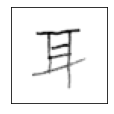

In [148]:
from tensorflow import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import PIL as pil


train_images_before = np.load("kanji_train_images.npz")['arr_0']
train_labels = np.load("kanji_train_labels.npz")['arr_0']

if K.image_data_format() == "channels_first":
  train_images = train_images.reshape(train_images_before.shape[0], 1,rows,cols)
  shape = (1,rows,cols)
else:
  train_images = train_images.reshape(train_images_before.shape[0], rows, cols, 1)
  shape = (rows,cols,1)

model = keras.models.load_model("kanji.h5") 
output = model.predict(np.expand_dims(train_images[27], axis=0))
predicted_class = np.argmax(output)
match = train_labels[27]

my_dpi =2
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(127*px,128*px))
plt.subplot(1,1,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(train_images_before[27], cmap=plt.cm.binary)
plt.show()
image2 = Image.fromarray((train_images_before[27]*255).astype(np.uint8))
image2 = image2.convert("L")
image2 = pil.ImageOps.invert(image2)
image2.save('filename2.png', format='PNG')

1/1 [==============================] - 3s 3s/step


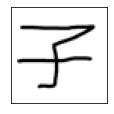

In [157]:
# load image and convert to and from NumPy array
from PIL import Image
import PIL as pil
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
# load the image
image = Image.open('ko.jpg').convert('RGB')
# convert image to numpy array

#image = image
image = pil.ImageOps.invert(image)
image = image.resize((64,64)).convert('L')
data = (np.asarray(image).astype(np.float32)/255)

model = keras.models.load_model("kanji.h5") 

# check prediction
getready = data.reshape(64,64,1)
output = model.predict(np.expand_dims(getready, axis=0))
predicted_class = np.argmax(output)


my_dpi =2
px = 1/plt.rcParams['figure.dpi']
plt.figure(figsize=(127*px,128*px))
plt.subplot(1,1,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data, cmap=plt.cm.binary)
plt.show()

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import skimage.transform as tr
from keras import backend as K
import matplotlib
from pathlib import Path

import matplotlib.font_manager as fm


kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

heatmap_images_before = np.zeros([(879), 64, 64], dtype=np.float32)


#train_labels_numbers = [26,64,158,209,321,328,331,394,480,610,683,750,793,876]
h = 0
for i in range(883):
	if( i == 88 or i  == 219 or i  == 349 or i  == 457 ): 
		h +=1
		continue
	else :
			heatmap_images_before[(i-h)] = tr.resize(kan[i*160+11],(64,64))

heatmap_labels_numbers = np.arange(879)
#train_labels = np.repeat(train_labels_numbers, 160)

if K.image_data_format() == "channels_first":
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 1,64,64)
else:
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 64, 64, 1)

model = keras.models.load_model("kanji.h5") 
output = model.predict(heatmap_images_before)

heatmap_images_after = np.zeros(len(heatmap_labels_numbers), dtype=np.int64)
heatmap_images_after = np.argmax(output,axis=1)
#for i in range(len(heatmap_labels_numbers)):
#  print(i,": ",heatmap_images_after[i])

print()
for i in range(len(heatmap_images_after)):
    if(heatmap_images_after[i]!= i):
        print(i, ": ", heatmap_images_after[i])


28/28 [==============================] - 4s 27ms/step



In [4]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import skimage.transform as tr
from keras import backend as K
import matplotlib
from pathlib import Path

import matplotlib.font_manager as fm


kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)

heatmap_images_before = np.zeros([(879), 64, 64], dtype=np.float32)


#train_labels_numbers = [26,64,158,209,321,328,331,394,480,610,683,750,793,876]
for j in range(160):
	heatmap_images_before = np.zeros([(879), 64, 64], dtype=np.float32)
	h = 0
	for i in range(883):
		if( i == 88 or i  == 219 or i  == 349 or i  == 457 ): 
			h +=1
			continue
		else :
				heatmap_images_before[(i-h)] = tr.resize(kan[i*160+j],(64,64))

	heatmap_labels_numbers = np.arange(879)
	#train_labels = np.repeat(train_labels_numbers, 160)

	if K.image_data_format() == "channels_first":
	  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 1,64,64)
	else:
	  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 64, 64, 1)

	model = keras.models.load_model("kanji.h5") 
	output = model.predict(heatmap_images_before)

	heatmap_images_after = np.zeros(len(heatmap_labels_numbers), dtype=np.int64)
	heatmap_images_after = np.argmax(output,axis=1)
	#for i in range(len(heatmap_labels_numbers)):
	#  print(i,": ",heatmap_images_after[i])

	print()
	for i in range(len(heatmap_images_after)):
	    if(heatmap_images_after[i]!= i):
	        print(j,": [",i, ": ", heatmap_images_after[i],"]")

28/28 [==============================] - 6s 66ms/step

0 : [ 25 :  87 ]
0 : [ 174 :  294 ]
28/28 [==============================] - 4s 30ms/step

28/28 [==============================] - 4s 31ms/step

28/28 [==============================] - 4s 32ms/step

3 : [ 94 :  616 ]
28/28 [==============================] - 4s 29ms/step

4 : [ 125 :  538 ]
4 : [ 169 :  715 ]
28/28 [==============================] - 4s 30ms/step

5 : [ 408 :  759 ]
28/28 [==============================] - 4s 28ms/step

6 : [ 103 :  11 ]
6 : [ 169 :  715 ]
28/28 [==============================] - 4s 29ms/step

7 : [ 82 :  411 ]
7 : [ 169 :  715 ]
28/28 [==============================] - 4s 28ms/step

28/28 [==============================] - 4s 28ms/step

9 : [ 179 :  98 ]
9 : [ 300 :  773 ]
9 : [ 447 :  216 ]
28/28 [==============================] - 4s 30ms/step

28/28 [==============================] - 4s 27ms/step

28/28 [==============================] - 4s 30ms/step

28/28 [==============================] - 4s 

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import skimage.transform as tr
from keras import backend as K
import matplotlib
from pathlib import Path
import seaborn as sns
import matplotlib.font_manager as fm


kan = np.load("kanji.npz")['arr_0'].reshape([-1, 127, 128]).astype(np.float32)

kan = kan/np.max(kan)



heatmap_images_before = np.zeros([879, 64, 64], dtype=np.float32)


#train_labels_numbers = [26,64,158,209,321,328,331,394,480,610,683,750,793,876]
h = 0
for i in range(883):
	if( i == 88 or i  == 219 or i  == 349 or i  == 457 ): 
		h +=1
		continue
	else :
		heatmap_images_before[(i-h)] = tr.resize(kan[i*160],(64,64))

heatmap_labels_numbers = np.arange(879)
#train_labels = np.repeat(train_labels_numbers, 160)

if K.image_data_format() == "channels_first":
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 1,64,64)
else:
  heatmap_images_before = heatmap_images_before.reshape(heatmap_images_before.shape[0], 64, 64, 1)

model = keras.models.load_model("kanji.h5") 
output = model.predict(heatmap_images_before)


from kanjiList import label
fpath = Path(matplotlib.get_data_path(), "fonts/ttf/NotoSansJP-Regular.otf")

sns.set_theme()
f, ax = plt.subplots(figsize=(200, 200))
res = sns.heatmap(output, annot=True, fmt=".3f", linewidths=.5, ax=ax)
res.set_xticks(np.arange(output.shape[0]),labels=label, fontsize = 18, font=fpath)
res.set_yticks(np.arange(output.shape[0]),labels=label, fontsize = 18, font=fpath)
plt.show()

28/28 [==============================] - 4s 30ms/step
